In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# ---------------- Load Dataset ----------------
df = pd.read_csv("uber.csv")   
print("Initial Shape:", df.shape)


Initial Shape: (200000, 9)


In [3]:
# ---------------- Pre-Processing ----------------
df.columns = df.columns.str.lower()

In [4]:
# Convert datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

In [5]:
# Remove missing and non-positive fares
df = df.dropna(subset=['fare_amount', 'pickup_longitude', 'pickup_latitude', 
                       'dropoff_longitude', 'dropoff_latitude'])
df = df[df['fare_amount'] > 0]

In [6]:
# Distance using Haversine Formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                              df['dropoff_latitude'], df['dropoff_longitude'])

df = df[df['distance_km'] > 0]

In [7]:
# Extract time features
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday


In [8]:
# ---------------- Identify Outliers ----------------
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['fare_amount'] >= Q1 - 1.5*IQR) & (df['fare_amount'] <= Q3 + 1.5*IQR)]

print("After Removing Outliers:", df.shape)



After Removing Outliers: (177695, 12)


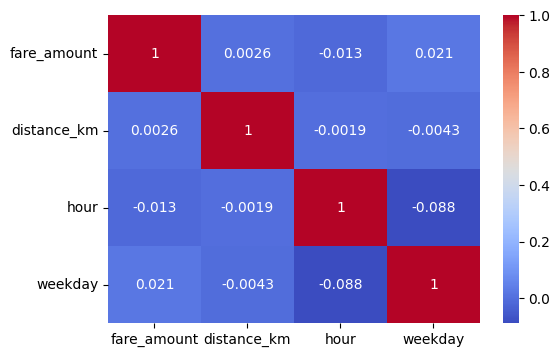

In [9]:
# ---------------- Correlation ----------------
plt.figure(figsize=(6,4))
sns.heatmap(df[['fare_amount','distance_km','hour','weekday']].corr(), annot=True, cmap='coolwarm')
plt.show()

In [10]:
# ---------------- Train Models ----------------
features = ['distance_km', 'hour', 'weekday']
X = df[features]
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Linear Regression
lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_test)

In [12]:
# Random Forest
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
pred_rf = rf.predict(X_test)

In [13]:
# ---------------- Evaluation ----------------
def evaluate(y, pred):
    return r2_score(y,pred), np.sqrt(mean_squared_error(y,pred)), mean_absolute_error(y,pred)

print("\nLinear Regression (R2, RMSE, MAE):", evaluate(y_test, pred_lr))
print("Random Forest (R2, RMSE, MAE):", evaluate(y_test, pred_rf))


Linear Regression (R2, RMSE, MAE): (0.0005808144540346838, np.float64(4.131805964456054), 3.2786686799606546)
Random Forest (R2, RMSE, MAE): (0.6521256652510017, np.float64(2.4376832408232127), 1.7548159815038877)
